# Inference on Hodgkin-Huxley model: tutorial

In this tutorial, we use `sbi` to do inference on a Hodgkin-Huxley model (Hodgkin and Huxley, 1952) with two parameters ($\bar g_{Na}$,$\bar g_K$), given a current-clamp recording (synthetically generated).

First we are going to import basic packages.

In [1]:
# GENERAL
import inspect
from typing import List, Dict, Optional, Union, Callable, Tuple
from warnings import warn

# MATH
import numpy as np
import torch

# VISUALIZATION
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

# sbi
import sbi.utils as utils

%load_ext autoreload
%autoreload 2

## Different required components

Before running inference, let us define the different required components:

1. observed data
2. model
3. prior over model parameters
4. summary statistics
5. generator class.

## Observed data

Let us assume we current-clamped a neuron and recorded the following voltage trace:


<img src="https://raw.githubusercontent.com/mackelab/delfi/master/docs/docs/tutorials/observed_voltage_trace.png" width="480">
<br>

In fact, this voltage trace was not measured experimentally but synthetically generated by simulating a Hodgkin-Huxley model with particular parameters ($\bar g_{Na}$,$\bar g_K$). We will come back to this point later in the tutorial.

## Model

We would like to infer the posterior over the two parameters ($\bar g_{Na}$,$\bar g_K$) of a Hodgkin-Huxley model, given the observed electrophysiological recording above. The model has channel kinetics as in Pospischil et al. 2008, and is defined by the following set of differential equations (parameters of interest highlighted in orange):

$$
\scriptsize
\begin{align}
C_m\frac{dV}{dt}&=g_1\left(E_1-V\right)+
                    \color{orange}{\bar{g}_{Na}}m^3h\left(E_{Na}-V\right)+
                    \color{orange}{\bar{g}_{K}}n^4\left(E_K-V\right)+
                    \bar{g}_Mp\left(E_K-V\right)+
                    I_{inj}+
                    \sigma\eta\left(t\right)\\
\frac{dq}{dt}&=\frac{q_\infty\left(V\right)-q}{\tau_q\left(V\right)},\;q\in\{m,h,n,p\}
\end{align}
$$

where $V$ is the membrane potential, $C_m$ is the membrane capacitance, $g_{\text{l}}$ is the leak conductance, $E_{\text{l}}$ is the membrane reversal potential, $\bar{g}_c$ is the density of channels of type $c$ ($\text{Na}^+$, $\text{K}^+$, M), $E_c$ is the reversal potential of $c$, ($m$, $h$, $n$, $p$) are the respective channel gating kinetic variables, and $\sigma \eta(t)$ is the intrinsic neural noise. The right hand side of the voltage dynamics is composed of a leak current, a voltage-dependent $\text{Na}^+$ current, a delayed-rectifier $\text{K}^+$ current, a slow voltage-dependent $\text{K}^+$ current responsible for spike-frequency adaptation, and an injected current $I_{\text{inj}}$. Channel gating variables $q$ have dynamics fully characterized by the neuron membrane potential $V$, given the respective steady-state $q_{\infty}(V)$ and time constant $\tau_{q}(V)$ (details in Pospischil et al. 2008).

We are going to use a Current Clamp like input current $I_{\text{inj}}$. Such a stimulus is already implmented in the `HH_stimuli` module. A HH stimulator calls the stimulus with a step size dt and expects two equal-length vectors in return, one of time values and one of stimulus values.

In [31]:
from HH_stimuli import CurrentClamp

In [3]:
# STIMULUS PARAMETERS
onset = 10  # seconds
duration = 120  # seconds
current_level: float = 0.0005  # Siemens
axon_radius: float = 70.*1e-4  # cm


# stimulus initialization
stimulus = CurrentClamp(stim_onset=onset, duration=duration,
                       current_level=current_level,
                       axon_radius=axon_radius)

The Hodgkin-Huxley simulator is given by:

In [4]:
from HH_simulator import HHSimulator

In [5]:
#PARAMTERS
num_lines_to_print = 193

# get source code
hh_simulator_source = inspect.getsourcelines(HHSimulator)
max_num_lines = len(hh_simulator_source[0]) - 1

# print source code
print(''.join(hh_simulator_source[0][:min([num_lines_to_print, max_num_lines])]))

class HHSimulator(Simulator):
    """Hodgkin-Huxley Simulator"""

    __name__ = 'Hodgkin-Huxley Simulator'

    params = {'g_leak': 0.1,  # mS/cm2
              'gbar_M': 0.07,  # mS/cm2
              'tau_max': 6e2,  # ms
              'Vt': -60,  # mV
              'nois_fact': 0.1,  # uA/cm2
              'E_leak': -70,  # mV
              'C': 1.,  # uF/cm2
              'E_Na': 53,  # mV
              'E_K': -107,  # mV
              'V0': -70,  # mV
              'dt': 0.01,  # s
              'gbar_Na': 20.,  # mS/cm2
              'gbar_K': 15.,  # mS/cm2
              'ref_period': 0.5,  # s, refractory period
              'stimulus': CurrentClamp(duration=120, stim_onset=10)  # Callable[[float], Tuple[np.ndarray, np.ndarray]]
              }

    def __init__(self, seed: Optional[int] = None, inference_parameters: List[str] = ['gbar_Na', 'gbar_K'], **params):
        """Initializes a Hodgkin-Huxley simulator"""
        super().__init__()
        self.params.update(params)
 

To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:

In [6]:
# HHSimulator
hh_simulator = HHSimulator(inference_parameters=['gbar_Na', 'gbar_K'], stimulus=stimulus)

# simulate Hodgkin-Huxley model for 3 different parameter sets
params = np.array([[[50.], [1.]], [[4.], [1.5]], [[20.], [15.]]])  # [batch_size, num inference parameters, inference parameter dim]
sim_samples = hh_simulator(params.squeeze(), return_stats=False)

The resulting voltage traces look as follows:

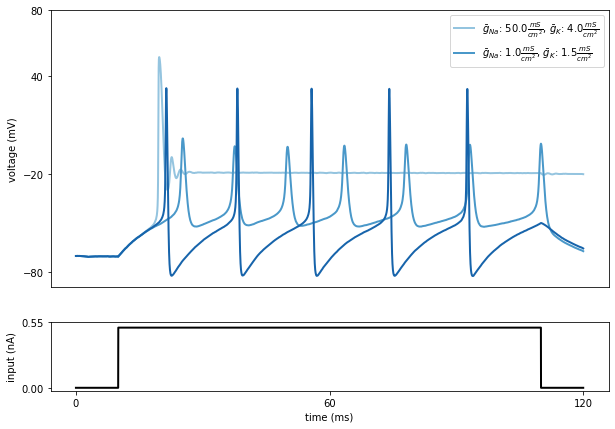

In [7]:
# colors for traces
col_min = 2
num_colors = len(sim_samples)+col_min
cm1 = mpl.cm.Blues
col1 = tuple(cm1(1.*i/num_colors) for i in range(col_min,num_colors))

# plotting
%matplotlib inline

fig = plt.figure(figsize=(10,7))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
ax.set_prop_cycle(cycler(color=col1))
label = [r', '.join([r'{0}: {1}$\frac{{mS}}{{cm^2}}$'.format(key, value[0]) for key, value in zip([r'$\bar{g}_{Na}$', r'$\bar{g}_{K}$'], params[:, i])]) for i in range(params.shape[1])]
plt.plot(np.tile(hh_simulator.t[None, :], (sim_samples.shape[0], 1,)).T, sim_samples.T, lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40, 80])
ax.legend(label)

ax = plt.subplot(gs[1])
plt.plot(hh_simulator.params['t'],hh_simulator.params['I']*hh_simulator.params['stimulus'].membrane_area*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, hh_simulator.t.max()/2, hh_simulator.t.max()])
ax.set_yticks([0, 1.1*(hh_simulator.params['I']*hh_simulator.params['stimulus'].membrane_area*1e3).max()])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

As can be seen, the voltage traces can be quite diverse for different parameter values. How can we infer the parameters ($\bar g_{Na}$,$\bar g_K$) underlying the particular observed voltage trace? `sbi` will allow us to solve this problem.

Note that it is not necessary to define the simulator as an entire callable class. `sbi` also takes a simple functions as simulator. Thus, `sbi` also has the flexibility to use simulators that utilize external packages, e.g., Brian (http://briansimulator.org/), nest (https://www.nest-simulator.org/), or NEURON (https://neuron.yale.edu/neuron/). External simulators do not even need to be Python-based as long as they store simulation outputs in a format that can be read from Python. All that might be necessary to wrap your external simulator of choice into a python callable that takes batches of parameters as input and gives batches of simulation results as outputs.

### Summary Statistics
Upon inspection of the simulator and the call to the simulator, you might have noticed that our simulator, by default, outputs summary statistics of the simulated voltage traces instead of the pure voltage traces. We do so for performance reasons, i.e. fitting our inference model to a target vector of reduced length needs less simulations/observations. Our summary statistics class returns number of spikes, mean resting potential, standard deviation of the resting potential, and the first 4 voltage moments, mean, standard deviation, skewness and kurtosis.

## Prior over model parameters

Now that we have the model and simulator class, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:

In [8]:
from sbi.utils.torchutils import BoxUniform

In [9]:
torch.manual_seed(2)
low = torch.Tensor([.5,1e-4])
high = torch.Tensor([80.,20.])

prior = BoxUniform(low=low, high=high)

## Inference
Now that we have all the required components, we can run inference with SNPE. We start by importing our SNPE object of choice.

In [10]:
from sbi.inference.snpe.snpe_c import SnpeC

Next, for our purposes, we are going to simulate a ground truth observation.

In [11]:
# GROUND TRUTH PARAMETERS
ground_truth_params = np.array([[20.], [15.]])

# SIMULATE GROUND TRUTH
ground_truth_voltage = hh_simulator(ground_truth_params.squeeze(), return_stats=False)
ground_truth_statistics = hh_simulator(ground_truth_params.squeeze())

The ground truth voltage traces look as follows:

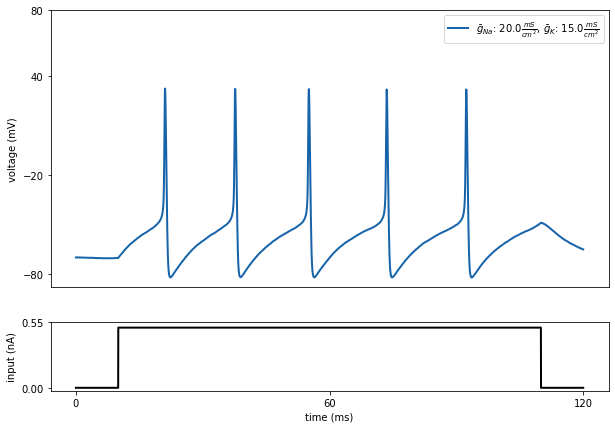

In [12]:
# colors for traces
col_min = 2
num_colors = len(sim_samples)+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

# plotting
%matplotlib inline

fig = plt.figure(figsize=(10,7))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(hh_simulator.t, ground_truth_voltage.numpy().squeeze(), color=col1[2], lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40, 80])
label = [r', '.join([r'{0}: {1}$\frac{{mS}}{{cm^2}}$'.format(key, value) for key, value in zip([r'$\bar{g}_{Na}$', r'$\bar{g}_{K}$'], ground_truth_params[:, i])]) for i in range(ground_truth_params.shape[1])]
ax.legend(label)

ax = plt.subplot(gs[1])
plt.plot(hh_simulator.t,hh_simulator.params['I']*hh_simulator.params['stimulus'].membrane_area*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, hh_simulator.params['t'].max()/2, hh_simulator.params['t'].max()])
ax.set_yticks([0, 1.1*(hh_simulator.params['I']*hh_simulator.params['stimulus'].membrane_area*1e3).max()])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

We instantiate the SNPE object...

In [22]:
# PARAMETERS
true_observation: np.ndarray = sim_samples
ground_truth_parameters: np.ndarray = params
num_pilot_samples = 100
simulation_batch_size = 1000

# NN
snpe_c = SnpeC(
    simulator=hh_simulator,
    prior=prior,
    true_observation=ground_truth_statistics,
    num_pilot_samples=num_pilot_samples, 
    simulation_batch_size=simulation_batch_size
)

(pseudo) setting parameter_dim to 2
(pseudo) setting observation_dim to 8


... and run the inference.

In [23]:
# PARAMETERS
num_rounds, num_simulations_per_round = 1, 4000

# INFERENCE
posterior = snpe_c(num_rounds=num_rounds, num_simulations_per_round=num_simulations_per_round)

100%|██████████| 1/1 [03:57<00:00, 237.03s/it]


Note that we chose the algorithm `SNPE-C`, but other algorithms are available within `sbi` (see http://www.mackelab.org/sbi). 

## Analysis of the results

After running the inference algorithm, let us inspect and analyse the results. We can start by checking whether the algorithm training has converged by inspecting the respective loss function:

In [24]:
# fig = plt.figure(figsize=(15,5))

# plt.plot(log[0]['loss'], lw=2)
# plt.xlabel('iteration')
# plt.ylabel('loss');

It seems that the loss function has converged. Let us inspect the inferred posterior distribution over the parameters ($\bar g_{Na}$,$\bar g_K$):

In [25]:
from sbi.utils.plot import *

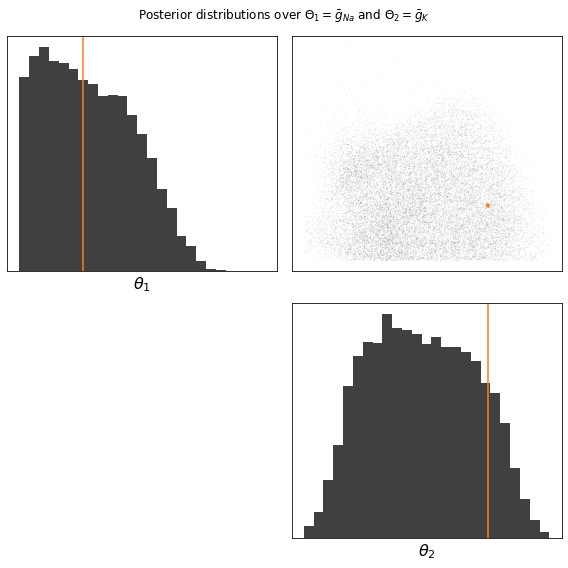

In [26]:
# PARAMETERS
num_samples = 20_000

# compute posterior samples
posterior_samples = posterior.sample(num_samples).reshape(-1,2).detach().numpy()

# plot marginals
fig = plot_hist_marginals(posterior_samples, 
                          ground_truth=ground_truth_params)
plt.suptitle(r'Posterior distributions over $\Theta_{1}=\bar{g}_{Na}$ and $\Theta_{2}=\bar{g}_{K}$')
plt.subplots_adjust(top=0.93)

As can be seen, the inferred posterior contains the ground-truth parameters (green) in a high-probability region. Now, let us sample parameters from the posterior distribution, simulate the Hodgkin-Huxley model for each of those samples and compare the simulations with the observed data:

In [27]:
# PARAMETERS
num_samp = 2

# sample from posterior
sample = posterior.sample(num_samp).detach().numpy()

# reject samples for which prior is zero
# ind = (sample > prior_min) & (sample < prior_max)
# params = sample[np.prod(ind,axis=1)==1]
params = sample

num_samp = len(params[:,0])

# simulate and plot samples
V = hh_simulator(params, return_stats=False)

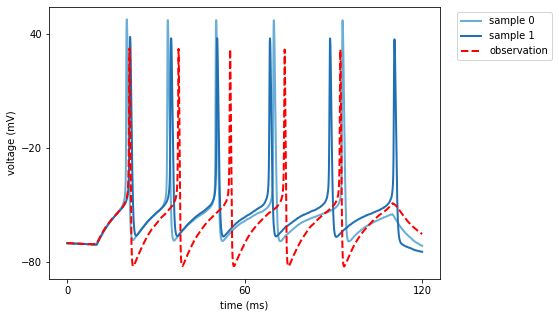

In [28]:
# PARAMETERS
# colors for traces
col_min = 2
num_colors = num_samp+col_min
cm1 = mpl.cm.Blues
col = tuple(cm1(1.*i/num_colors) for i in range(col_min,num_colors))

# plot samples
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(cycler(color=col))
ax.plot(np.tile(hh_simulator.params['t'][None, :], (num_samp,1,)).T, V.T, lw=2)

# plot ground truth
ax.plot(hh_simulator.t, ground_truth_voltage.squeeze(), '--',lw=2, color='red')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

labels = ['sample {}'.format(i) for i in range(num_samp)] + ['observation']
ax.legend(labels, bbox_to_anchor=(1.3, 1), loc='upper right')

ax.set_xticks([0, hh_simulator.params['stimulus'].duration/2, hh_simulator.params['stimulus'].duration])
ax.set_yticks([-80, -20, 40]);

As can be seen, the samples from the inferred posterior lead to simulations that closely resemble the observed data, confirming that `SNPE-C` did a good job at capturing the observed data.

## References


A. L. Hodgkin and A. F. Huxley. A quantitative description of membrane current and its application to conduction and excitation in nerve. The Journal of Physiology, 117(4):500–544, 1952.

M. Pospischil, M. Toledo-Rodriguez, C. Monier, Z. Piwkowska, T. Bal, Y. Frégnac, H. Markram, and A. Destexhe. Minimal Hodgkin-Huxley type models for different classes of cortical and thalamic neurons. Biological Cybernetics, 99(4-5), 2008.

This example, including the notebook itself, as well as the modules HH_simulator.py, HH_stimuli.py, and HH_statistics.py, are based on the quickstart [Hodgkin Huxley example in the sbi sucessor delfi](https://github.com/mackelab/delfi/blob/master/docs/docs/tutorials/quickstart.ipynb).